### Подключение библиотек

In [78]:
import sympy as smp
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.patches as mpatches
import matplotlib.lines
import math

### Символьные переменные

In [79]:
k,r,R,m,M,t,g = smp.symbols(r"k r R m M t g") #константы
phi,x = smp.symbols(r"\phi x",cls = smp.Function) #обощенные координаты

phi = phi(t)
phi_d = smp.diff(phi,t)
phi_dd = smp.diff(phi_d,t)

x = x(t)
x_d = smp.diff(x,t)
x_dd = smp.diff(x_d,t)


### Лагранжиан системы

##### Кинетическая энергия

In [80]:
T = (m+M)*(x_d**2)*smp.Rational(1,2)+m*x_d*phi_d*(R-r)*smp.cos(phi)+smp.Rational(3,4)*m*(phi_d**2)*((R-r)**2)
T

3*m*(R - r)**2*Derivative(\phi(t), t)**2/4 + m*(R - r)*cos(\phi(t))*Derivative(\phi(t), t)*Derivative(x(t), t) + (M + m)*Derivative(x(t), t)**2/2

##### Потенциальная энергия

In [81]:
P = k*(x**2)*smp.Rational(1,2)-m*g*(R-r)*smp.cos(phi)
P

-g*m*(R - r)*cos(\phi(t)) + k*x(t)**2/2

##### Лагранжиан и уравнения Лагранжа

In [82]:
L = T-P
eq_1 = (smp.diff(smp.diff(L,x_d),t)-smp.diff(L,x)).simplify() 
eq_2 = (smp.diff(smp.diff(L,phi_d),t)-smp.diff(L,phi)).simplify()

In [83]:
eq_1

k*x(t) - m*(R - r)*sin(\phi(t))*Derivative(\phi(t), t)**2 + m*(R - r)*cos(\phi(t))*Derivative(\phi(t), (t, 2)) + (M + m)*Derivative(x(t), (t, 2))

In [84]:
eq_2

m*(R - r)*(2*g*sin(\phi(t)) + 3*(R - r)*Derivative(\phi(t), (t, 2)) + 2*cos(\phi(t))*Derivative(x(t), (t, 2)))/2

### Решение системы дифференциальных уравнений

In [85]:
sols = smp.solve([eq_1,eq_2],[x_dd,phi_dd],rational = False,simplify = False) # выражаем вторую производную по x и по phi

In [86]:
w_x_d_f = smp.lambdify((g,m,M,r,R,k,x,phi,x_d,phi_d),sols[x_dd])
x_d_f = smp.lambdify(x_d,x_d)
phi_d_f = smp.lambdify(phi_d,phi_d)
w_phi_d_f = smp.lambdify((g,m,M,r,R,k,x,phi,x_d,phi_d),sols[phi_dd])

In [87]:
def system(S,t):
    x,w_x,phi,w_phi = S
    return [
        x_d_f(w_x),
        w_x_d_f(g,m,M,r,R,k,x,phi,w_x,w_phi),
        phi_d_f(w_phi),
        w_phi_d_f(g,m,M,r,R,k,x,phi,w_x,w_phi)
    ]

##### Начальные условия

In [88]:
g = 9.81
M = 3
m = 2.5
r = 0.8
R = 2
k = 5
a = 3*R
t = np.linspace(0,20,1000)
spring_w,spring_nodesQ = 2,32
eqPos = 12
start = [5,0,np.pi/3,0]
ans = odeint(system,y0 = start,t = t)

##### Переменные для анимации

In [89]:
box_center = (ans.T[0],[a/2]*ans.shape[0])
cyl_center = ((np.sin(ans.T[2])*(R-r)+box_center[0],-np.cos(ans.T[2])*(R-r)+box_center[1]))
box_left_corner = (ans.T[0]-a/2,[0]*ans.shape[0])
spring_end_point = ((ans.T[0]-a/2,[a/2]*ans.shape[0]))

Text(0.5, 1.0, 'Координата центра маленького цилиндра по оси $y$')

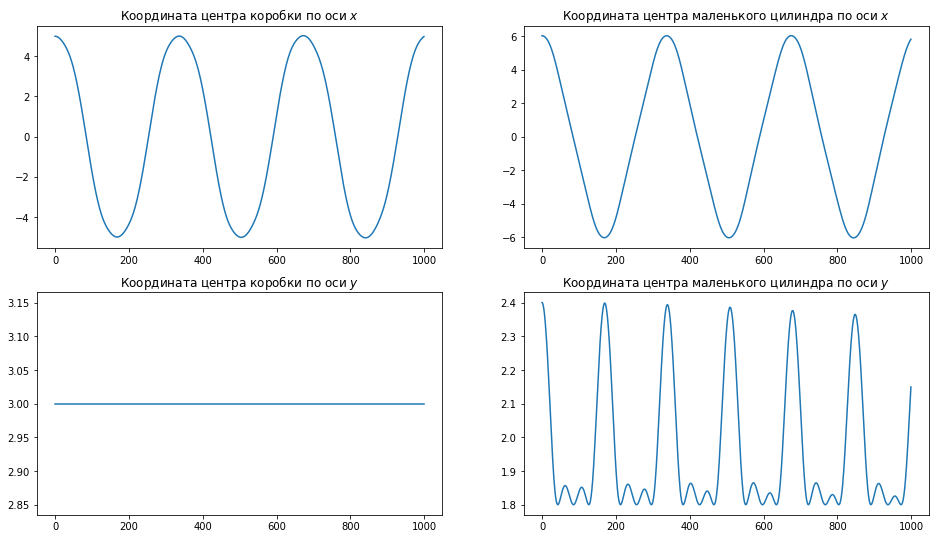

In [90]:
fig,ax = plt.subplots(2,2,figsize = (16,9))
ax[0,0].plot(box_center[0])
ax[0,0].set_title("Координата центра коробки по оси $x$")

ax[1,0].plot(box_center[1])
ax[1,0].set_title("Координата центра коробки по оси $y$")

ax[0,1].plot(cyl_center[0])
ax[0,1].set_title("Координата центра маленького цилиндра по оси $x$")

ax[1,1].plot(cyl_center[1])
ax[1,1].set_title("Координата центра маленького цилиндра по оси $y$")

In [91]:
# Функция, просчитывающая пружину
def springNodes(start, end, nodes, width):
    """!
    Return a list of points corresponding to a spring.
    @param r1 (array-like) The (x, y) coordinates of the first endpoint.
    @param r2 (array-like) The (x, y) coordinates of the second endpoint.
    @param nodes (int) The number of spring "nodes" or coils.
    @param width (int or float) The diameter of the spring.
    @return An array of x coordinates and an array of y coordinates.
    """

    # Check that nodes is at least 1.
    nodes = max(int(nodes), 1)

    # Convert to numpy array to account for inputs of different types/shapes.
    start, end = np.array(start).reshape((2,)), np.array(end).reshape((2,))

    # If both points are coincident, return the x and y coords of one of them.
    if (start == end).all():
        return start[0], start[1]

    # Calculate length of spring (distance between endpoints).
    length = np.linalg.norm(np.subtract(end, start))

    # Calculate unit vectors tangent (u_t) and normal (u_t) to spring.
    u_t = np.subtract(end, start) / length
    u_n = np.array([[0, -1], [1, 0]]).dot(u_t)

    # Initialize array of x (row 0) and y (row 1) coords of the nodes+2 points.
    spring_coords = np.zeros((2, nodes + 2))
    spring_coords[:,0], spring_coords[:,-1] = start, end

    # Check that length is not greater than the total length the spring
    # can extend (otherwise, math domain error will result), and compute the
    # normal distance from the centerline of the spring.
    normal_dist = math.sqrt(max(0, width**2 - (length**2 / nodes**2))) / 2

    # Compute the coordinates of each point (each node).
    for i in range(1, nodes + 1):
        spring_coords[:,i] = (
            start
            + ((length * (2 * i - 1) * u_t) / (2 * nodes))
            + (normal_dist * (-1)**i * u_n))

    return spring_coords[0,:], spring_coords[1,:]

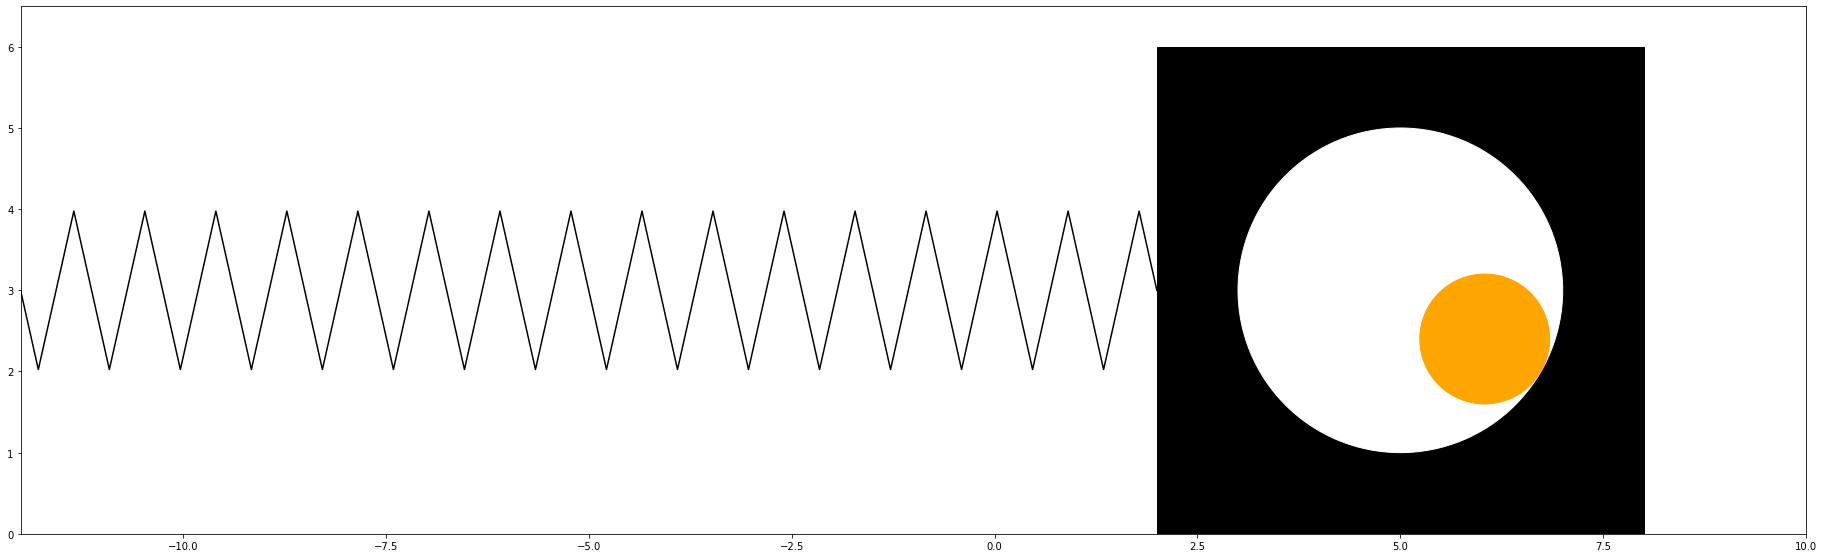

In [93]:
c1 = plt.Circle((box_center[0][0],box_center[1][0]),R,fill = True,animated = True,zorder = 2,color = 'white')
c2 = plt.Circle((cyl_center[0][0],cyl_center[1][0]),r,color = 'orange',fill = True,animated = True,zorder = 3)
box = plt.Rectangle((box_left_corner[0][0],box_left_corner[1][0]),a,a,fill = True,color = "black",animated = True)
spring = matplotlib.lines.Line2D(*springNodes((-eqPos,a/2),(spring_end_point[0][0],spring_end_point[1][0]),spring_nodesQ,spring_w),color = 'black')
                    

# massRatio = mpatches.Patch(color='red', label=r'$M/m = '+str(float(2))+r"$")
# xStart = mpatches.Patch(color='green', label=r'$x_{0} = '+str(start[0])+r"$")
# phiStart = mpatches.Patch(color='blue', label=r'$\phi_{0} = \pi/3'+r"$")
# springConst = mpatches.Patch(color='red', label=r'$k = '+str(k)+r"$")

fig = plt.figure(figsize=(32,16))

ax = plt.axes(xlim=(-1*eqPos, 10), ylim=(0, 6.5))
ax.set_aspect('equal')

def init():
    ax.add_patch(box)
    ax.add_patch(c1)
    ax.add_patch(c2)
    ax.add_line(spring)
    # ax.legend(handles=[massRatio,xStart,phiStart,springConst],prop = {'size': 10})
    return [c1,c2]

def animate(i):
    spring.set_xdata(springNodes((-eqPos,a/2),(spring_end_point[0][i],spring_end_point[1][i]),spring_nodesQ,spring_w)[0])
    spring.set_ydata(springNodes((-eqPos,a/2),(spring_end_point[0][i],spring_end_point[1][i]),spring_nodesQ,spring_w)[1])
    box.set_xy((box_left_corner[0][i],box_left_corner[1][i]))
    c1.set_center((box_center[0][i],box_center[1][i]))
    c2.set_center((cyl_center[0][i],cyl_center[1][i]))

    # ax.plot([cyl_center[0][0:i]],[cyl_center[1][0:i]],color = 'red')
    return [c1,c2]


anim = FuncAnimation(fig, animate, init_func=init,
                     frames=1000, interval=60, blit=True)
plt.show()
anim.save('animation_1.mp4', fps=60,
          extra_args=['-vcodec', 'libx264', 
                      '-pix_fmt', 'yuv420p'])